<div align="right"><font size="3"><b>Amnay Kanane</font></b></div>

# Where to live in Paris ?

# Introduction

### Description & Discussion of the Background

Paris, one of the most beautiful cities in the world, seduces with its great architectural and cultural heritage wich is constantly modernized and refined. Paris could quickly fill up in the coming years, according to a study by The National Institute of Statistics and Economic Studies.

However, the housing market in Paris is considered "tense" given its density of 20.754 people per km2, making it the 8th most densely populated city in the world ahead of Seoul.

Through this project, I'll try to find the best neighborhoods to live in the city of Paris. As moving to a new city requires prior research and a global vision of its neighborhoods, I'll use some data and exploration tools to have an overall view and then to move to some specifics such as the venues categories in each neighborhood and their frequencies/proprotion.

This analysis will allow us to group the different neighborhoods of Paris in clusters, and thus help us better compare their characteristics.

As the rent prince is a decisive criterion in the choice of accommodation, we will see how the rent in Paris varies from neighborhood to neighborhood and compare its distribution with those clusters.

This project could be useful to anyone interested in moving to Paris and, more generally, -by following the same approach- to any other city around the world, as long as the data is available.



### Data description

* We will need a dataset that contains all the boroughs of Paris and the neighbourhoods that exist in each borough as well as the coordinates of each neighborhood. Hopefully, I found a dataset that matches perfectly our needs, and it is available at : https://opendata.paris.fr/explore/dataset/quartier_paris

* We will also use Foursquare API to explore these neighborhoods and extract any information we need to lead our analysis.

* We will also use a distribution of reference rents over the city of Paris, available at : https://opendata.paris.fr/explore/dataset/logement-encadrement-des-loyers/information/?disjunctive.id_zone&disjunctive.nom_quartier&disjunctive.piece&disjunctive.epoque&disjunctive.meuble_txt

### Methodology

* **Data Cleaning and Preparation:**
    * Clean the data and convert it to a suitable for to analysis
    * Use Foursquare API to get location data and information about the venues
* **Data visualization:**
    * Neighborhood's visualization using Folium (mapping librairy)
    * Data visualization and plotting
* **Machine Learning:**
    * K-means clustering to group Neighborhoods into clusters.
* **Discussion and Conclusions:**
    * Results of cluster's comparison
    * Limitations and leads to improve the analysis

# Development

### Imports 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
mpl.style.use('ggplot') 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore Dataset

### Neighborhoods

#### Read the data & examine the dataframe

In [2]:
neighborhoods= pd.read_csv('quartier_paris.csv', sep=";")
neighborhoods.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000048,48,7511204,Quinze-Vingts,12,750000012,4509.486974,1.235916e+06,"48.8469159441,2.37440162648","{""type"": ""Polygon"", ""coordinates"": [[[2.373204..."
1,750000027,27,7510703,Ecole-Militaire,7,750000007,3887.703157,8.078708e+05,"48.8503592615,2.31103093627","{""type"": ""Polygon"", ""coordinates"": [[[2.320083..."
2,750000059,59,7511503,Grenelle,15,750000015,4932.937240,1.478299e+06,"48.8501716555,2.2918526427","{""type"": ""Polygon"", ""coordinates"": [[[2.300883..."
3,750000061,61,7511601,Auteuil,16,750000016,12452.253931,6.383888e+06,"48.8506223427,2.25227690754","{""type"": ""Polygon"", ""coordinates"": [[[2.249224..."
4,750000009,9,7510301,Arts-et-Métiers,3,750000003,2482.460453,3.180877e+05,"48.8664702895,2.35708313106","{""type"": ""Polygon"", ""coordinates"": [[[2.360209..."


According to the description provided with the database, we are dealing with surface and descriptive graphic data. We will be using only the neighborhood's names, the boroughs to which they are affiliated and their coordinates.

In [3]:
# rename columns
neighborhoods.rename(columns={'L_QU' : 'Neighborhood',
                               'C_AR' : 'Borough',
                               'Geometry X Y' : 'Coordinates'},
                     inplace=True)

# select the columns that we need
neighborhoods = neighborhoods[['Neighborhood','Borough','Coordinates']]

# split coordinates in lat/long coordinates and convert their types
neighborhoods[['Latitude','Longitude']] = neighborhoods.Coordinates.apply(lambda x: pd.Series(str(x).split(",")))
neighborhoods = neighborhoods.astype({'Latitude' : float,
                                       'Longitude' : float})
neighborhoods.drop('Coordinates', axis=1, inplace=True)

neighborhoods.head()

,Neighborhood,Borough,Latitude,Longitude
0,Quinze-Vingts,12,48.846916,2.374402
1,Ecole-Militaire,7,48.850359,2.311031
2,Grenelle,15,48.850172,2.291853
3,Auteuil,16,48.850622,2.252277
4,Arts-et-Métiers,3,48.866470,2.357083


Still according to the description, Paris has 20 boroughs. Each borough is divided in four administrative neighborhoods. Paris thus has 80 administrative neighborhoods. Let's make sure of it.

In [4]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 20 boroughs and 80 neighborhoods.


#### Visualize Paris and its neighborhoods

Get Latitude and Longitude coordinates of Paris using Nominatim

In [5]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="Python-urllib")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566969, 2.3514616.


#### Create a map of Paris with neighborhoods superimposed on top.

In [6]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

### Rent Prices

In [7]:
paris_rent = pd.read_csv('logement-encadrement-des-loyers.csv', sep=";")

paris_rent.head()

,Secteurs géographiques,Numéro du quartier,Nom du quartier,Nombre de pièces principales,Epoque de construction,Type de location,Loyers de référence,Loyers de référence majorés,Loyers de référence minorés,Année,Ville,Numéro INSEE du quartier,geo_shape,geo_point_2d
0,2,13,Saint-Merri,3,1946-1970,non meublé,21.5,25.8,15.1,2017,PARIS,7510413,"{""type"": ""Polygon"", ""coordinates"": [[[2.352623...","48.8585213723,2.35166696714"
1,2,22,Odeon,4,Apres 1990,non meublé,26.4,31.7,18.5,2017,PARIS,7510622,"{""type"": ""Polygon"", ""coordinates"": [[[2.336988...","48.8478006293,2.33633882759"
2,1,23,Notre-Dame-des-Champs,2,Avant 1946,non meublé,27.9,33.5,19.5,2017,PARIS,7510623,"{""type"": ""Polygon"", ""coordinates"": [[[2.336756...","48.846427594,2.32735687823"
3,1,23,Notre-Dame-des-Champs,3,1971-1990,non meublé,26.2,31.4,18.3,2017,PARIS,7510623,"{""type"": ""Polygon"", ""coordinates"": [[[2.336756...","48.846427594,2.32735687823"
4,1,23,Notre-Dame-des-Champs,3,1971-1990,meublé,29.6,35.5,20.7,2017,PARIS,7510623,"{""type"": ""Polygon"", ""coordinates"": [[[2.336756...","48.846427594,2.32735687823"


In [8]:
paris_rent.rename(columns={'Nom du quartier' : 'Neighborhood',
                           'Loyers de référence' : 'Rent'},
                  inplace=True)
paris_rent = paris_rent[['Neighborhood','Rent']]

paris_rent.head()

,Neighborhood,Rent
0,Saint-Merri,21.5
1,Odeon,26.4
2,Notre-Dame-des-Champs,27.9
3,Notre-Dame-des-Champs,26.2
4,Notre-Dame-des-Champs,29.6


In [9]:
paris_rent_grouped = paris_rent.groupby('Neighborhood',as_index=False).mean()
paris_rent_grouped.head()

,Neighborhood,Rent
0,Amérique,20.600000
1,Archives,26.659375
2,Arsenal,27.915625
3,Arts-et-Metiers,26.659375
4,Auteuil,25.137500


## 2. Neighbourhood's exploration

#### Define Foursquare Credentials and Version

In [41]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


#### Create a function that explore all neighbourhoods in our dataframe

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
paris_venues_extract = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Quinze-Vingts
Ecole-Militaire
Grenelle
Auteuil
Arts-et-Métiers
Archives
Faubourg-du-Roule
Monnaie
Odéon
Champs-Elysées
Maison-Blanche
Croulebarbe
Rochechouart
Bercy
Halles
Invalides
Faubourg-Montmartre
Gaillon
Amérique
Val-de-Grâce
Necker
Père-Lachaise
La Chapelle
Sorbonne
Saint-Georges
Chaussée-d'Antin
Palais-Royal
Saint-Gervais
Saint-Thomas-d'Aquin
Porte-Saint-Denis
Saint-Germain-l'Auxerrois
Villette
Saint-Victor
Madeleine
Saint-Fargeau
Porte-Dauphine
Grandes-Carrières
Batignolles
Saint-Merri
Notre-Dame
Gros-Caillou
Europe
Sainte-Marguerite
Parc-de-Montsouris
Saint-Lambert
Folie-Méricourt
Salpêtrière
Place-Vendôme
Combat
Charonne
Javel
Sainte-Avoie
Hôpital-Saint-Louis
Belleville
Ternes
Notre-Dame-des-Champs
Petit-Montrouge
Pont-de-Flandre
Muette
Chaillot
Epinettes
Vivienne
Enfants-Rouges
Saint-Germain-des-Prés
Saint-Vincent-de-Paul
Saint-Ambroise
Bel-Air
Montparnasse
Plaine de Monceaux
Mail
Bonne-Nouvelle
Gare
Clignancourt
Goutte-d'Or
Arsenal
Jardin-des-Plantes
Porte-Saint-Martin
Roq

In [13]:
paris_venues = paris_venues_extract.copy()

#### Let's check the size of the resulting dataframe

In [14]:
print(paris_venues.shape)
paris_venues.head()

(5350, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Quinze-Vingts,48.846916,2.374402,Promenade plantée – La Coulée Verte,48.847632,2.375107,Trail
1,Quinze-Vingts,48.846916,2.374402,Les Embruns,48.847100,2.371883,Creperie
2,Quinze-Vingts,48.846916,2.374402,Le Calbar,48.848702,2.375487,Cocktail Bar
3,Quinze-Vingts,48.846916,2.374402,Le Pop-Up du Label,48.847497,2.375483,Bar
4,Quinze-Vingts,48.846916,2.374402,Viaduc des Arts,48.848664,2.372931,Bridge


#### Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 296 uniques categories.


**Remark:**  
The categories provided by Foursquare are too precise for our analysis, let's try to move to a higher level of granularity in order to better visualize the different types of venues in each area. Example: we want all categories of restaurants to form a single Food category. Fortunately, the Foursquare categorization system is hierarchical, we will use it to perform these groupings.

#### Let's get the hierarchical list of categories applied to venues

In [16]:
# create URL
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET,
    VERSION) 
# display results
categories = requests.get(url).json()['response']

The difficulty we're facing here is that what the API provides is a 3 depth tree categorization.

We have categories, 1-sub-categories and 2-sub-categories and 3-sub_categories

we will need to browse the tree and extract all leaf nodes (sub and 2-sub and 3-sub categories) that will match with the categories Foursquare provides for each venue.

After that, we will "cut" the tree by grouping those leaf nodes so that we can classify our venues into higher-level granularity categories, wich are :

In [17]:
len_cats = len(categories['categories'])
[categories['categories'][j]['name'] for j in range (len_cats)]

['Arts & Entertainment',
 'College & University',
 'Event',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Residence',
 'Shop & Service',
 'Travel & Transport']

In [18]:
df = pd.DataFrame(columns=['Cat', 'Category'])

In [20]:
for j in range (len_cats) :
    listcat = []
    listsubsubcat = []
    len_subcats = len(categories['categories'][j]['categories'])
    for i in range (0,len_subcats) :
        listcat.append(categories['categories'][j]['categories'][i]['name'])
        len_subsubcats = len(categories['categories'][j]['categories'][i]['categories'])
        # it's not leaf node
        if len_subsubcats > 0 :
            listsubcat = [categories['categories'][j]['categories'][i]['categories'][k]['name'] for k in range (len_subsubcats)]
            listcat.extend(listsubcat)
            for k in range (len_subsubcats) :
                len_subsubsubcats = len(categories['categories'][j]['categories'][i]['categories'][k]['categories'])
                if len_subsubsubcats > 0 :
                     listsubsubcat = [categories['categories'][j]['categories'][i]['categories'][k]['categories'][r] for r in range (len_subsubsubcats)]
                listcat.extend(listsubsubcat)
    for l in listcat:
        name = categories['categories'][j]['name']
        df = df.append({'Cat' : str(l),
                        'Category' : str(name)}, ignore_index=True)

In [22]:
print(df.shape)
df.head()

(1660, 2)


,Cat,Category
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
4,Bowling Alley,Arts & Entertainment


In [23]:
paris_venues.rename(columns={'Venue Category' : 'Cat'},inplace=True)
paris_venues = pd.merge(paris_venues, df, on='Cat', how='left')
paris_venues.drop('Cat', axis=1, inplace=True)

### Rent prices

## 3. Neighbourhood's analysis

In [24]:
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category
0,Quinze-Vingts,48.846916,2.374402,Promenade plantée – La Coulée Verte,48.847632,2.375107,Outdoors & Recreation
1,Quinze-Vingts,48.846916,2.374402,Les Embruns,48.847100,2.371883,Food
2,Quinze-Vingts,48.846916,2.374402,Le Calbar,48.848702,2.375487,Nightlife Spot
3,Quinze-Vingts,48.846916,2.374402,Le Pop-Up du Label,48.847497,2.375483,Nightlife Spot
4,Quinze-Vingts,48.846916,2.374402,Viaduc des Arts,48.848664,2.372931,Outdoors & Recreation


In [25]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Quinze-Vingts,0,0,0,0,1,0,0,0
1,Quinze-Vingts,0,0,1,0,0,0,0,0
2,Quinze-Vingts,0,0,0,1,0,0,0,0
3,Quinze-Vingts,0,0,0,1,0,0,0,0
4,Quinze-Vingts,0,0,0,0,1,0,0,0


#### Next, let's group rows by neighborhood and and summing the occurrences of each category

In [26]:
paris_grouped = paris_onehot.groupby('Neighborhood').sum().reset_index()
paris_grouped.head()

,Neighborhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,Amérique,0,0,5,0,3,0,2,1
1,Archives,6,0,55,8,5,1,19,5
2,Arsenal,3,0,37,5,10,0,5,7
3,Arts-et-Métiers,7,0,59,16,1,0,9,6
4,Auteuil,3,0,1,0,8,1,1,0


In [27]:
def return_most_common_cats(row, num_top_cats):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cats]

#### Now let's create a new dataframe and display the top categories of venues in each neighborhood.

In [28]:
num_top_cats = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_cats):
    try:
        columns.append('{}{} Most Common Cat'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Cat'.format(ind+1))

# create a new dataframe
neighborhoods_cats_sorted = pd.DataFrame(columns=columns)
neighborhoods_cats_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_cats_sorted.iloc[ind, 1:] = return_most_common_cats(paris_grouped.iloc[ind, :], num_top_cats)

neighborhoods_cats_sorted.head()

,Neighborhood,1st Most Common Cat,2nd Most Common Cat,3rd Most Common Cat,4th Most Common Cat,5th Most Common Cat,6th Most Common Cat,7th Most Common Cat
0,Amérique,Food,Outdoors & Recreation,Shop & Service,Travel & Transport,Professional & Other Places,Nightlife Spot,College & University
1,Archives,Food,Shop & Service,Nightlife Spot,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Professional & Other Places
2,Arsenal,Food,Outdoors & Recreation,Travel & Transport,Shop & Service,Nightlife Spot,Arts & Entertainment,Professional & Other Places
3,Arts-et-Métiers,Food,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Professional & Other Places
4,Auteuil,Outdoors & Recreation,Arts & Entertainment,Shop & Service,Professional & Other Places,Food,Travel & Transport,Nightlife Spot


## 4. Cluster Neighborhoods

To cluster these neighborhoods, we will use the K-means algorithm. I'll start by using the "Elbow Method" to find the appropriate number of clusters in the dataset.

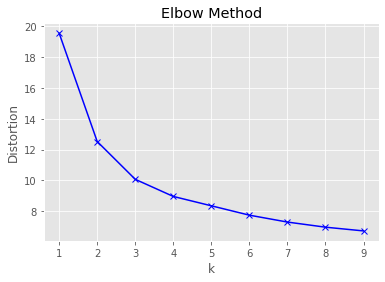

In [29]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
    kmeanModel = KMeans(n_clusters=k).fit(paris_grouped_clustering)
    kmeanModel.fit(paris_grouped_clustering)
    distortions.append(sum(np.min(cdist(paris_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / paris_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

The elbow method shows that the number of clusters should be 3.

In [30]:
kclusters = 3

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels

array([2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 0, 2, 1, 2, 0, 1,
       1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 1, 1, 2, 0, 1,
       1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 1, 0, 0, 1], dtype=int32)

In [31]:
paris_grouped_clustering.head()

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,0,0,5,0,3,0,2,1
1,6,0,55,8,5,1,19,5
2,3,0,37,5,10,0,5,7
3,7,0,59,16,1,0,9,6
4,3,0,1,0,8,1,1,0


#### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [32]:
# add clustering labels
neighborhoods_cats_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_cats_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Cat,2nd Most Common Cat,3rd Most Common Cat,4th Most Common Cat,5th Most Common Cat,6th Most Common Cat,7th Most Common Cat
0,Quinze-Vingts,12,48.846916,2.374402,1,Food,Shop & Service,Travel & Transport,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,College & University
1,Ecole-Militaire,7,48.850359,2.311031,2,Food,Travel & Transport,Outdoors & Recreation,Shop & Service,Arts & Entertainment,Professional & Other Places,Nightlife Spot
2,Grenelle,15,48.850172,2.291853,0,Food,Travel & Transport,Shop & Service,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,College & University
3,Auteuil,16,48.850622,2.252277,2,Outdoors & Recreation,Arts & Entertainment,Shop & Service,Professional & Other Places,Food,Travel & Transport,Nightlife Spot
4,Arts-et-Métiers,3,48.866470,2.357083,1,Food,Nightlife Spot,Shop & Service,Arts & Entertainment,Travel & Transport,Outdoors & Recreation,Professional & Other Places


#### Finally, let's visualize the resulting clusters

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Let us now examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [34]:
paris_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
paris_clustered = paris_grouped.groupby('Cluster Labels').mean()
paris_clustered

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Cluster Labels,,,,,,,,
0,3.916667,0.000000,30.250000,4.375000,4.291667,0.166667,7.416667,5.916667
1,4.973684,0.026316,52.973684,9.315789,4.473684,0.368421,12.263158,7.815789
2,0.944444,0.000000,9.777778,0.944444,3.000000,0.055556,2.555556,2.333333


#### Let's create a pie charts for each cluster to visualize the proprotion of each category in each cluster

###### Cluster 0

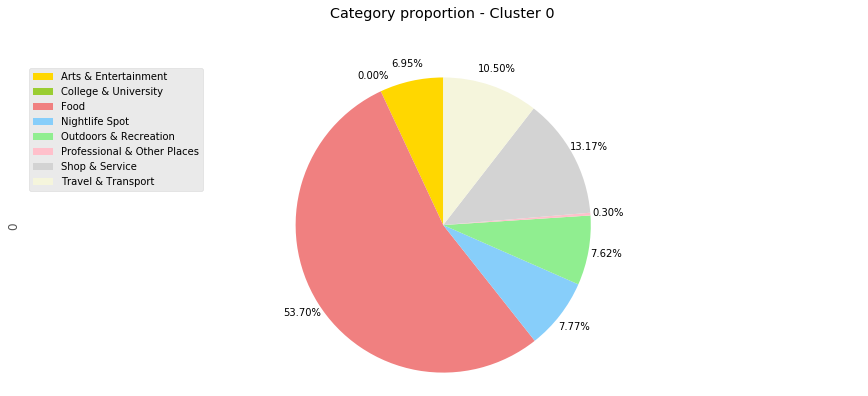

In [35]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'lightgrey','beige']
paris_clustered.iloc[0].plot(kind='pie',
                            figsize=(15,6),
                            autopct='%1.2f%%', 
                            startangle=90,    
                            shadow=False,  
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,  # the ratio between the center of each pie slice and the start of the text generated by autopct
                            colors=colors_list
                            )
plt.title('Category proportion - Cluster 0', y=1.12) 

plt.axis('equal')
# add legend
plt.legend(labels=paris_clustered.columns, loc='upper left') 
plt.show()

###### Cluster 1

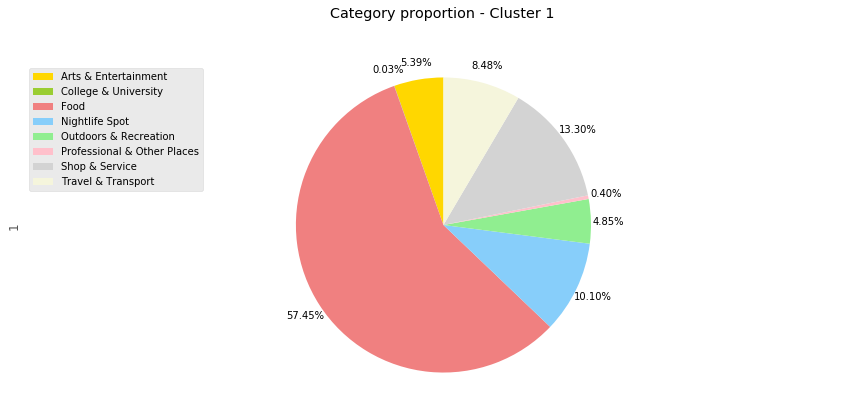

In [36]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'lightgrey','beige']
paris_clustered.iloc[1].plot(kind='pie',
                            figsize=(15,6),
                            autopct='%1.2f%%', 
                            startangle=90,    
                            shadow=False,  
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,  # the ratio between the center of each pie slice and the start of the text generated by autopct
                            colors=colors_list
                            )
plt.title('Category proportion - Cluster 1', y=1.12) 

plt.axis('equal')
# add legend
plt.legend(labels=paris_clustered.columns, loc='upper left') 
plt.show()

##### Cluster 2

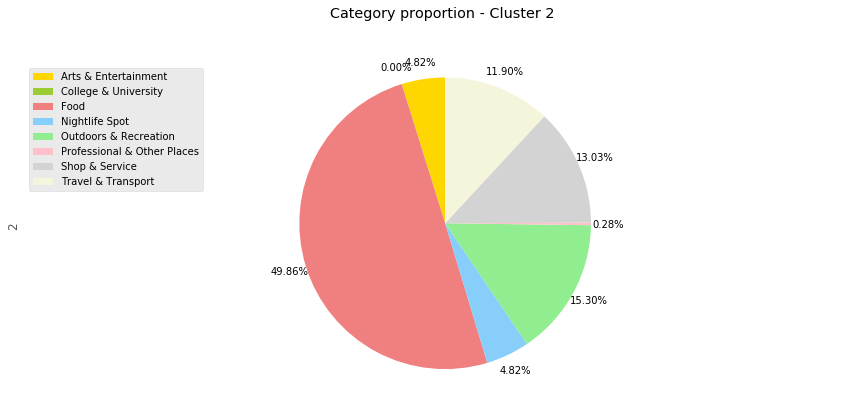

In [37]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'lightgrey','beige']
paris_clustered.iloc[2].plot(kind='pie',
                            figsize=(15,6),
                            autopct='%1.2f%%', 
                            startangle=90,    
                            shadow=False,  
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,  # the ratio between the center of each pie slice and the start of the text generated by autopct
                            colors=colors_list
                            )
plt.title('Category proportion - Cluster 2', y=1.12) 

plt.axis('equal')
# add legend
plt.legend(labels=paris_clustered.columns, loc='upper left') 
plt.show()

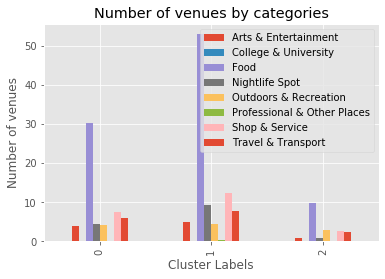

In [38]:
paris_clustered.plot(kind='bar')

plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of venues by categories') # add title to the plot

plt.show()

#### Let's label each cluster based on the above visualizations

* Cluster 0 : "Reasonably lively" (Urban Core)
* Cluster 1 : "Very lively and professional " (Urban Core)
* Cluster 2 : "Calm and recreational" (Suburbs)

#### Now that we have our neighborhoods clustered and labeled, let's see how the rent varies between these clusters

In [39]:
quartiers = r'quartier_paris.geojson'
paris_map_rent = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')


paris_map_rent2 = folium.Map(location=[latitude, longitude], zoom_start=12, tiles='Mapbox Bright')
paris_map_rent2.choropleth(
    geo_data=quartiers,
    data=paris_rent_grouped,
    columns=['Neighborhood','Rent'],
    key_on='feature.properties.l_qu',
    fill_color='Greens', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Rent'
)

# display map
# paris_map_rent


markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(paris_map_rent2)
    
paris_map_rent2

## 6. Results

Using to the geographic data of the districts of Paris, we were able to explore Paris through an interactive map.

Then, by using the Foursquare API, we were able to collect information on the venues in each district. Wanting to have a global understanding of the neighborhoods, we decided to go back into the hierarchy of categories in order to manipulate more global categories and therefore have a more global vision of neighborhoods.

We were able, using the k'means algorithm, to cluster the 80 neighborhoods into 3 clusters :

  * Cluster 0 : "Reasonably lively" (Urban Core)
  * Cluster 1 : "Very lively and professional " (Urban Core)
  * Cluster 2 : "Calm and recreational" (Suburbs)

and comfront them to the distibution of price rents, wich confirm the intuitive fact that the rent prices increase with liveliness of the neighborhoods.

# Conclusion

I think that the objective of having a global vision of Paris is reached, we know now what it is and what it would cost to leave in each neighborhood.  

The next step would naturally be to focus on each cluster and take into account more specific parameters like the cateogories initially provided by Foursquare. For example, having all the different kind of restaurants could give us a better idea about the cosmopolitanism of some Neighborhoods.

# References

* [1] [Open Data Paris](https://opendata.paris.fr/)
* [2] [Foursquare](https://foursquare.com/)